In [1]:
!rm -rf dataset

In [2]:
import os
import json
from collections import Counter
from tqdm import tqdm
# define directories
IMAGE_DIR = './dataset_ka/train/images/'
ANNOTATIONS_DIR = './dataset_ka/train/annotations'

# get the list of images
image_filenames = os.listdir(IMAGE_DIR)

In [3]:
CLASSES = ["x-label","y-label","diagram-tick"]

In [4]:
def convert_to_bbox(polygon):
    return [polygon['x0'], polygon['y0'], polygon['x1'], polygon['y1'],polygon['x2'],polygon['y2'],polygon['x3'],polygon['y3']]

def point_to_bbox(point, k=5):
    x = point['x']
    y = point['y'] 
    return [x, y]

def point_to_bbox_tuple(x,y, k=5):
    return [x, y]

In [5]:
import re
# def is_number(s: str):
#     s = re.sub('[,$% ]', '', s)
#     try:
#         float(s)
#         return True
#     except ValueError:
#         return False
def get_number(s):
    if type(s)==str:
        s=re.sub('[$% ]', '', s)
        s=re.sub('[,]', '.', s)
        return float(s)
    else:
        return float(s)

def translate_dataseries_to_chart(dataseries, x_tickinfo, y_tickinfo,ctype):
    # Check if x and y labels are numerical
#     print(x_tickinfo)
#     print(y_tickinfo)
    x_labels_numerical = all(not isinstance(label["x"],str) for label in dataseries)
    y_labels_numerical = all(not isinstance(label["y"],str) for label in dataseries)

    if x_labels_numerical:
        divisor=1
        if all("%" in label for label in x_tickinfo.keys()):
            divisor=100
        
        # Convert y_tickinfo keys to float for comparison
        x_ticks = {get_number(k)/divisor: v for k, v in x_tickinfo.items()}

        # Sort the y_ticks dictionary by key
        x_ticks = dict(sorted(x_ticks.items()))

        # List of y_ticks keys and values for interpolation
        x_values = list(x_ticks.keys())
        x_coords = list(x_ticks.values())
    else:
        # Create a mapping from x labels to their coordinates
        x_mapping = {label: info['x'] for label, info in x_tickinfo.items()}

    if y_labels_numerical:
        divisor=1
        if all("%" in label for label in y_tickinfo.keys()):
            divisor=100
        # Convert y_tickinfo keys to float for comparison
        y_ticks = {get_number(k)/divisor: v for k, v in y_tickinfo.items()}

        # Sort the y_ticks dictionary by key
        y_ticks = dict(sorted(y_ticks.items()))

        # List of y_ticks keys and values for interpolation
        y_values = list(y_ticks.keys())
        y_coords = list(y_ticks.values())
    else:
        # Create a mapping from y labels to their coordinates
        y_mapping = {label: info['y'] for label, info in y_tickinfo.items()}

    result = []
    for point in dataseries:
        x_val = point['x']
        y_val = point['y']

        if x_labels_numerical:
            x_val = get_number(x_val)
            # Find the two y_ticks that y_val falls between
            for i in range(len(x_values) - 1):
                if x_values[i] <= x_val <= x_values[i + 1]:
                    # Linear interpolation of x_val to y_coord
                    ratio = (x_val - x_values[i]) / (x_values[i + 1] - x_values[i])
                    x_coord = x_coords[i]['x'] + ratio * (x_coords[i + 1]['x'] - x_coords[i]['x'])
                    break
            else:  # y_val >= maximum y_values[i]
                ratio = (x_val - x_values[0]) / (x_values[-1] - x_values[0])
                x_coord = x_coords[0]['x'] + ratio * (x_coords[-1]['x'] - x_coords[0]['x'])
        else:
            x_coord = x_mapping[x_val]

        if y_labels_numerical:
            y_val = get_number(y_val)

            # Find the two y_ticks that y_val falls between
            for i in range(len(y_values) - 1):
                if y_values[i] <= y_val <= y_values[i + 1]:
                    # Linear interpolation of y_val to y_coord
                    ratio = (y_val - y_values[i]) / (y_values[i + 1] - y_values[i])
                    y_coord = y_coords[i]['y'] + ratio * (y_coords[i + 1]['y'] - y_coords[i]['y'])
                    break
            else:  # y_val >= maximum y_values[i]
                ratio = (y_val - y_values[0]) / (y_values[-1] - y_values[0])
                y_coord = y_coords[0]['y'] + ratio * (y_coords[-1]['y'] - y_coords[0]['y'])

        else:
            # For non-numerical data, find the closest y tick
#             closest_y_label = min(y_mapping.keys(), key=lambda label: abs(float(label) - y_val))
            y_coord = y_mapping[y_val]

        # Append (x_coord, y_coord) to result
        result.append((x_coord, y_coord))

    return result


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import random

def plot_image_with_annotations(image_path, annotation_path):
    # Open the image file
    img = Image.open(image_path)
    
    fig, ax = plt.subplots(1,figsize=(12, 12))
    ax.imshow(img)

    # Define a list of colors for different classes
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    # Open the annotation file
    with open(annotation_path) as f:
        lines = f.readlines()

    for line in lines:
        # Split the line into parts
        parts = line.strip().split()

        # Extract the class index and the bounding box coordinates
        class_index = int(parts[0])
        coords = list(map(float, parts[1:]))

        # Create a polygon patch from the coordinates
        coords = np.array(coords).reshape(-1, 2) * [img.size]
        polygon = patches.Polygon(coords, linewidth=2, edgecolor=colors[class_index % len(colors)], facecolor='none')

        # Add the patch to the axes
        ax.add_patch(polygon)

    plt.show()


In [7]:
def get_id(texts,i):
    for k in texts:
        if i==k["id"]:
            return k
def get_bounding_box(points):
    xs = [p[0] for p in points]
    ys = [p[1] for p in points]
    x_min = min(xs)
    y_min = min(ys)
    x_max = max(xs)
    y_max = max(ys)
    return [x_min, y_min, x_max - x_min, y_max - y_min]
def create_square(point, k=10):
    if type(point)==dict:
        x,y = point["x"],point["y"]
    else:
        x,y =point
    half_k = k / 2.0

    # Define the corners of the square
    corners = [x - half_k, y - half_k,x + half_k, y - half_k,x + half_k, y + half_k,x - half_k, y + half_k]
    return corners
def polygon_to_bbox(polygon):
    # Create list of x and y coordinates
    x_coords = polygon[0::2]
    y_coords = polygon[1::2]

    # Compute minimum and maximum coordinates
    x_min, x_max = min(x_coords), max(x_coords)
    y_min, y_max = min(y_coords), max(y_coords)

    # Calculate the center of the bounding box
    x_center = (x_min + x_max) / 2.0
    y_center = (y_min + y_max) / 2.0

    # Calculate the width and height of the bounding box
    width = x_max - x_min
    height = y_max - y_min

    # Return the bounding box in the format [x, y, width, height]
    return [x_center, y_center, width, height]
def get_line_bboxes(v,ctype=None):
    texts = v["text"]
    polygon_info = []
    point_info = []
    x_tickinfo = {}
    y_tickinfo = {}

    for tinf in v["axes"]["x-axis"]["ticks"]:
        bbox_label = convert_to_bbox(get_id(texts,tinf["id"])["polygon"])
        polygon_info.append([0]+bbox_label)
#         point_info.append([2]+create_square(tinf["tick_pt"]))
        x_tickinfo[get_id(texts,tinf["id"])["text"]] = tinf["tick_pt"]

    for tinf in v["axes"]["y-axis"]["ticks"]:
        bbox_label = convert_to_bbox(get_id(texts,tinf["id"])["polygon"])
        polygon_info.append([1]+bbox_label)
#         point_info.append([3]+create_square(tinf["tick_pt"]))
        y_tickinfo[get_id(texts,tinf["id"])["text"]] = tinf["tick_pt"]
    if ctype=="horizontal_bar":
        x_tickinfo, y_tickinfo = y_tickinfo, x_tickinfo
    for (x,y) in translate_dataseries_to_chart(v['data-series'],x_tickinfo, y_tickinfo,ctype):
        point_info.append([2]+create_square([x,y]))
    
    return [[p[0]]+polygon_to_bbox(p[1:]) for p in polygon_info+point_info]

def get_line_bboxes_new(v,ctype=None):
    texts = v["task2"]["output"]["text_blocks"]
    polygon_info = []
    point_info = []
    x_tickinfo = {}
    y_tickinfo = {}

    for tinf in v["task4"]["output"]["axes"]["x-axis"]:
        bbox_label = convert_to_bbox(get_id(texts,tinf["id"])["polygon"])
        polygon_info.append([0]+bbox_label)
        x_tickinfo[get_id(texts,tinf["id"])["text"]] = tinf["tick_pt"]

    for tinf in v["task4"]["output"]["axes"]["y-axis"]:
        bbox_label = convert_to_bbox(get_id(texts,tinf["id"])["polygon"])
        polygon_info.append([1]+bbox_label)
        y_tickinfo[get_id(texts,tinf["id"])["text"]] = tinf["tick_pt"]
    if ctype=="horizontal bar":
        x_tickinfo, y_tickinfo = y_tickinfo, x_tickinfo
    dseries = v["task6"]["output"]["data series"][0]
    if ctype=="horizontal bar":
        for i in range(len(dseries["data"])):
            dseries["data"][i]["x"],dseries["data"][i]["y"] = dseries["data"][i]["y"],dseries["data"][i]["x"]
    ans_points=translate_dataseries_to_chart(dseries["data"],x_tickinfo, y_tickinfo,ctype)
    assert len(ans_points)>1
    if ctypee=="horizontal bar":
        assert len(ans_points)==len(y_tickinfo)
    elif ctypee!="scatter":
        assert len(ans_points)==len(x_tickinfo)
    for (x,y) in ans_points:
        point_info.append([2]+create_square([x,y]))
    return [[p[0]]+polygon_to_bbox(p[1:]) for p in polygon_info+point_info]


In [8]:
import cv2
import matplotlib.pyplot as plt
import random

# define 8 different colors for the 8 classes

def draw_boxes(image_path, data_file_path):
    # load image
    colors = [(random.randint(0,255), random.randint(0,255), random.randint(0,255)) for _ in range(8)]
    image = cv2.imread(image_path)
    image_height, image_width = image.shape[:2]
    plt.figure(figsize=(10,10))
    with open(data_file_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            data = line.strip().split()
            object_class, x_center, y_center, width, height = map(float, data)
            object_class = int(object_class)

            # denormalize coordinates and dimensions
            x_center *= image_width
            y_center *= image_height
            width *= image_width
            height *= image_height

            # calculate the top left and bottom right points
            x1 = int(x_center-width/2)
            y1 = int(y_center-height/2)
            x2 = int(x_center + width/2)
            y2 = int(y_center + height/2)

            # draw the bounding box on the image
            cv2.rectangle(image, (x1, y1), (x2, y2), colors[object_class], 2)

    # convert the image from BGR color space to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # display the image
    plt.imshow(image)
    plt.show()

In [9]:
os.makedirs("./dataset/valid/images",exist_ok=True)
os.makedirs("./dataset/valid/labels",exist_ok=True)
os.makedirs("./dataset/train/images",exist_ok=True)
os.makedirs("./dataset/train/labels",exist_ok=True)

In [10]:
import glob

In [11]:
train_images = sorted(glob.glob("./ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1.0/images/*/*"))
train_annots = sorted(glob.glob("./ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1.0/annotations_JSON/*/*"))

In [12]:
ALLOWED_CHARTS={}
ALLOWED_CHARTS["horizontal bar"]=4
ALLOWED_CHARTS["line"]=0
ALLOWED_CHARTS["scatter"]=3
ALLOWED_CHARTS["vertical bar"]=2

In [13]:
from PIL import Image
from IPython.display import clear_output
import shutil

558it [00:00, 1961.62it/s]

list index out of range
'[unnamed category #41]'
list index out of range
list index out of range
list index out of range
list index out of range


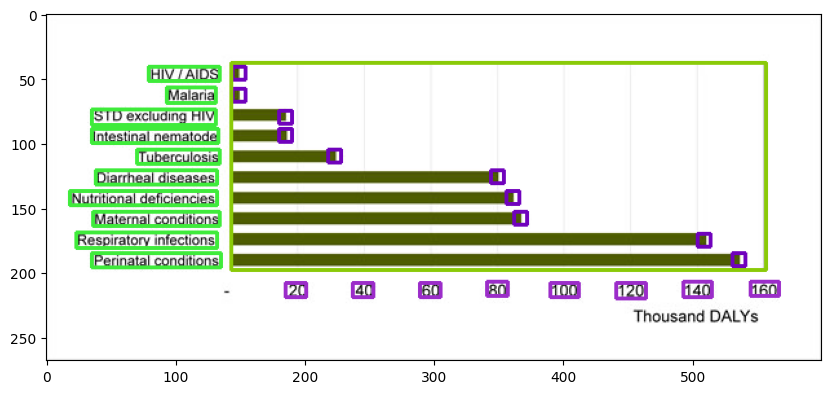


list index out of range
list index out of range


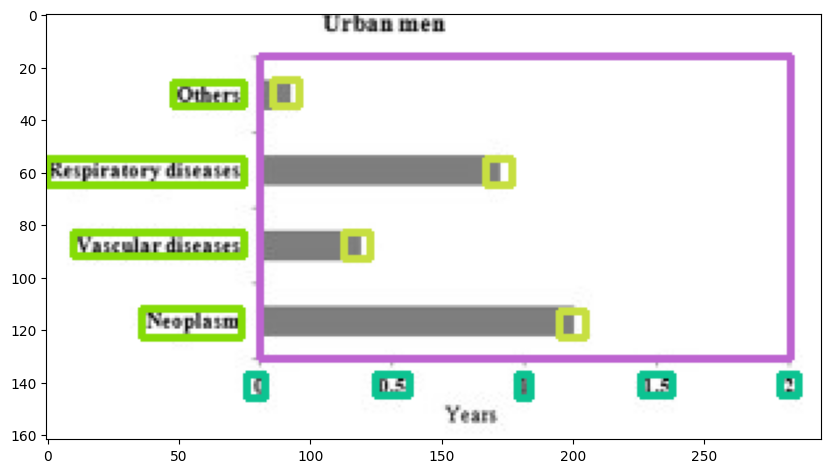

674it [00:01, 308.49it/s] 

list index out of range


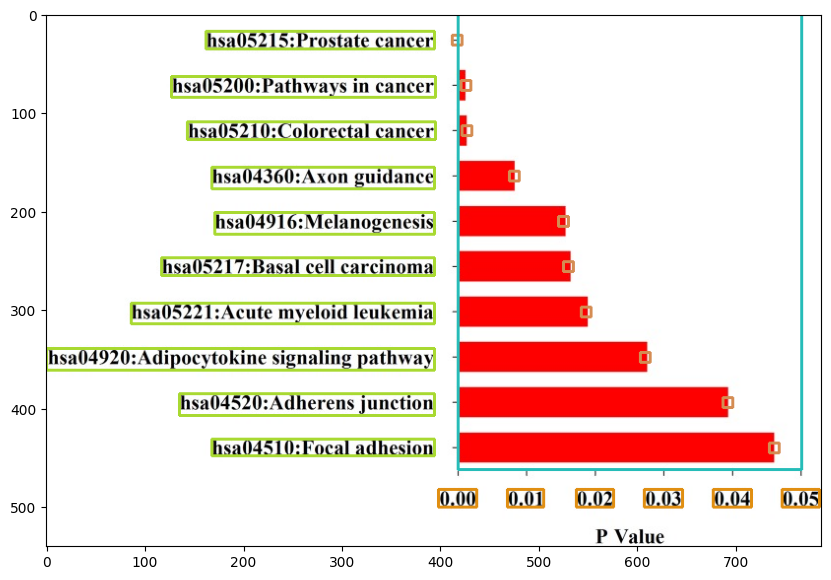

759it [00:01, 268.73it/s]

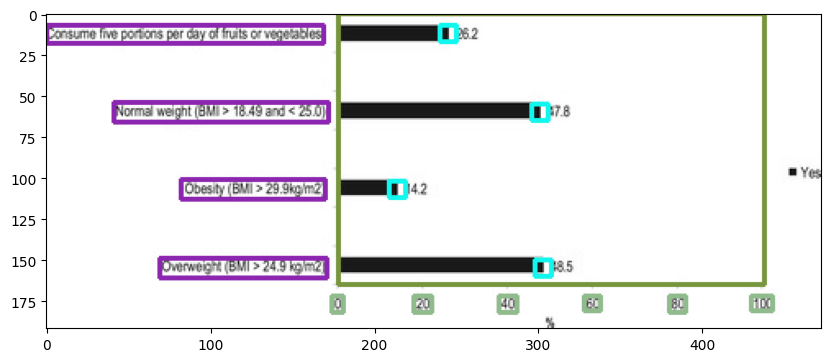

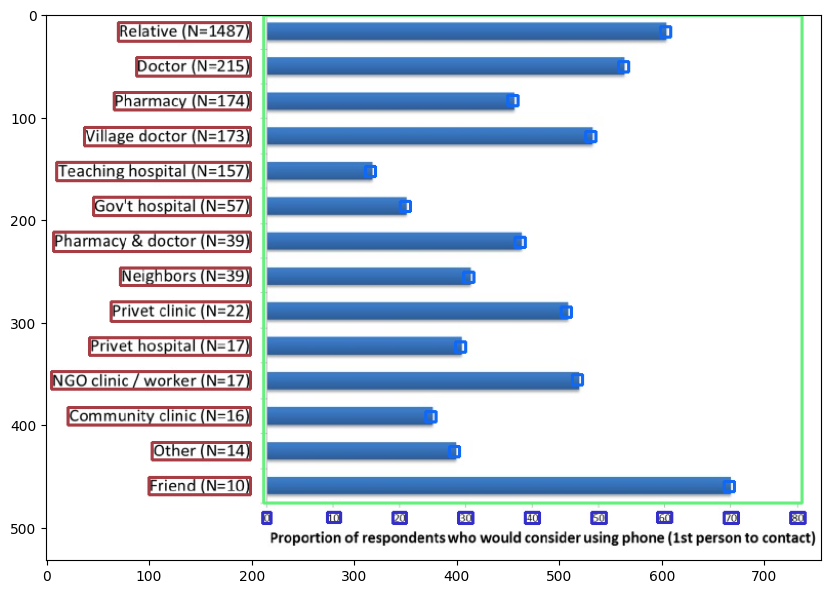

925it [00:02, 262.35it/s]

list index out of range



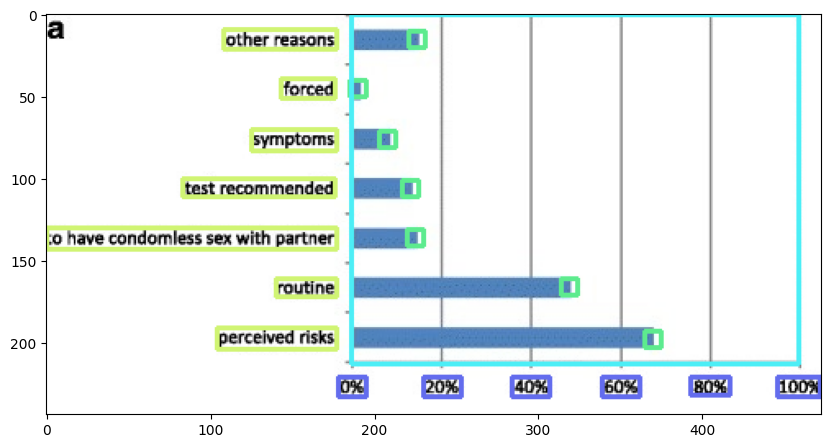

1051it [00:02, 265.84it/s]

could not convert string to float: '10^2'
list index out of range


1459it [00:03, 442.59it/s]

list index out of range



could not convert string to float: '<0.35'
could not convert string to float: '2.342*104'




2361it [00:03, 818.49it/s]

3090it [00:03, 1355.15it/s]

could not convert string to float: '1950s'










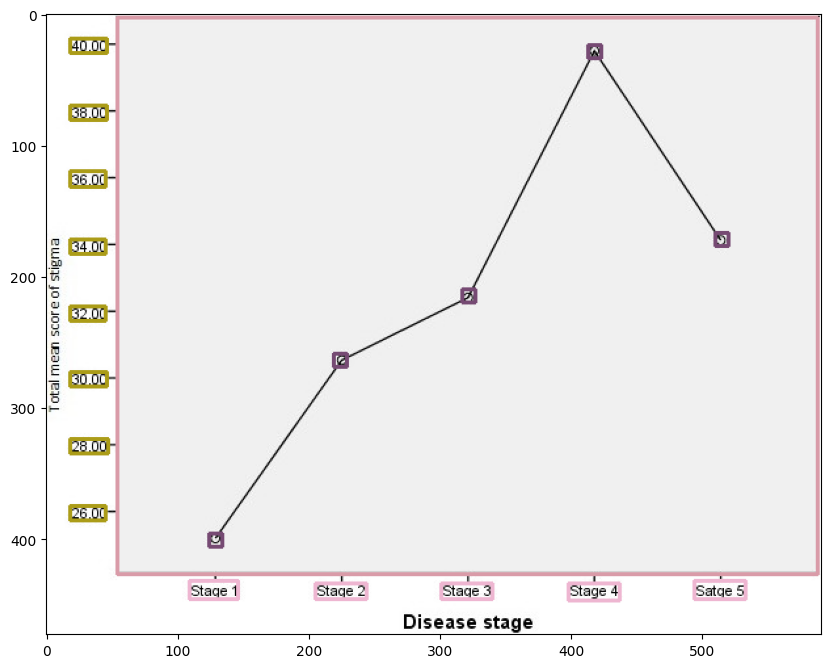

3743it [00:04, 1372.76it/s]

4634it [00:04, 2114.84it/s]



could not convert string to float: '65.000.00'













could not convert string to float: '£0'



list index out of range
list index out of range
list index out of range


4994it [00:04, 2393.63it/s]



list index out of range


list index out of range



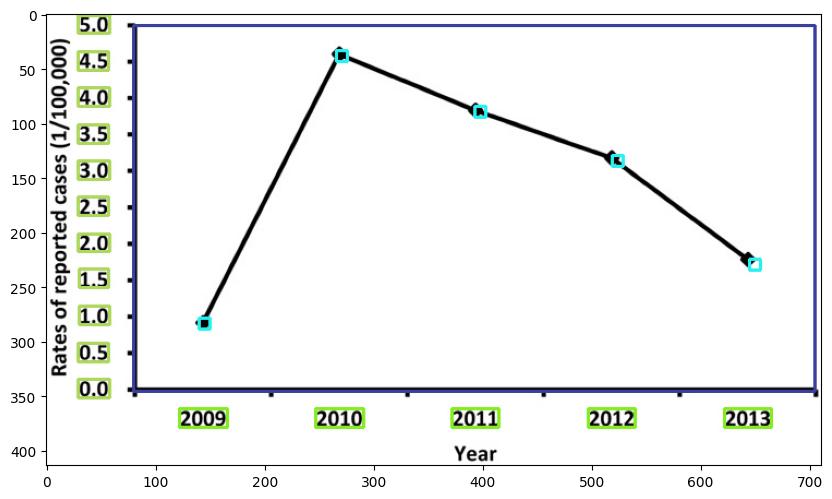

5682it [00:04, 1965.22it/s]







could not convert string to float: '10^{0}'



list index out of range









6605it [00:05, 2730.79it/s]

list index out of range
list index out of range


list index out of range






list index out of range

list index out of range



list index out of range


7677it [00:05, 3606.72it/s]










list index out of range

list index out of range




8565it [00:05, 3912.45it/s]


list index out of range





could not convert string to float: '1.000.0'











9605it [00:05, 4250.43it/s]


could not convert string to float: '10^0'


list index out of range



could not convert string to float: '1000m'

list index out of range













10585it [00:05, 4291.88it/s]










list index out of range










11488it [00:06, 4163.51it/s]

14177it [00:06, 5386.82it/s]



list index out of range
list index out of range



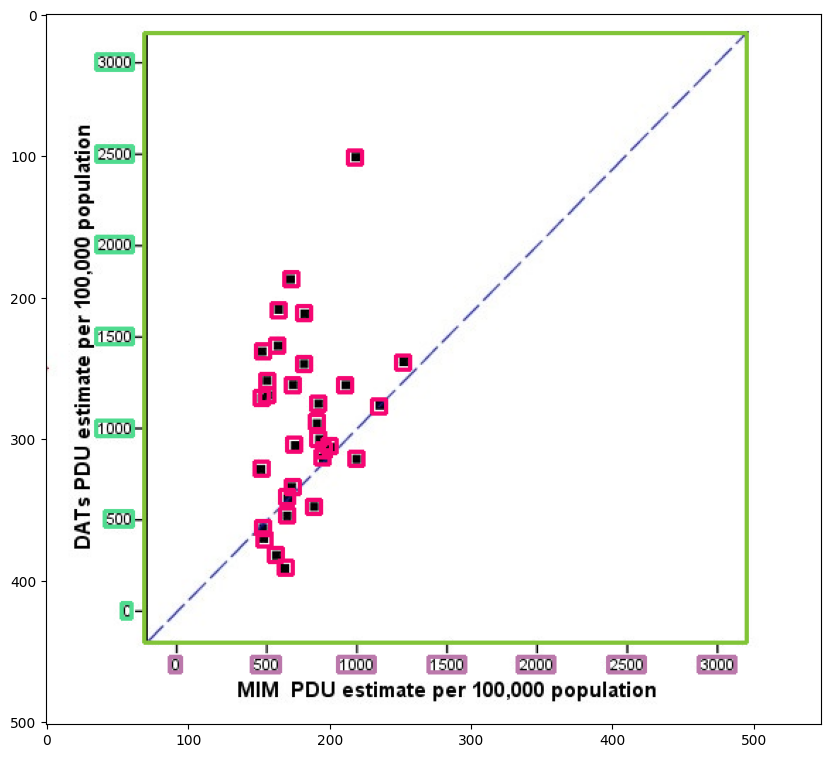

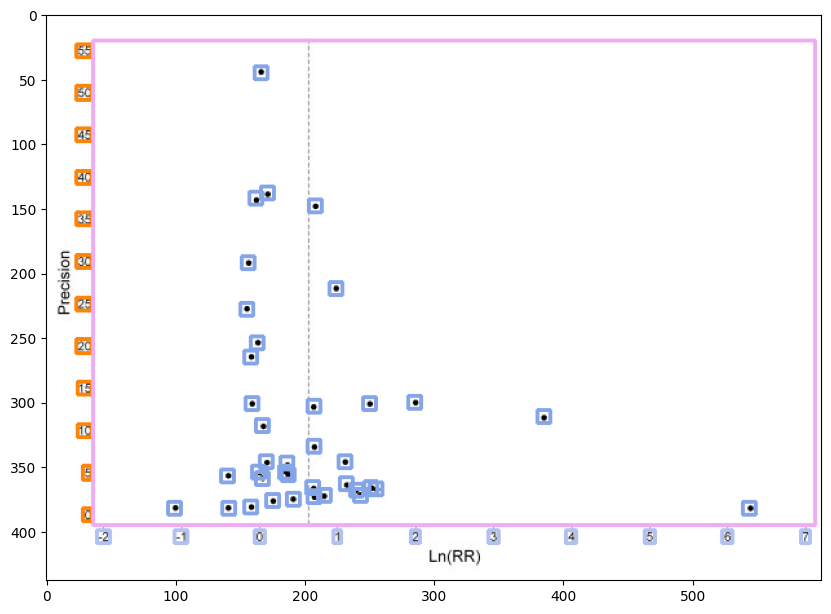

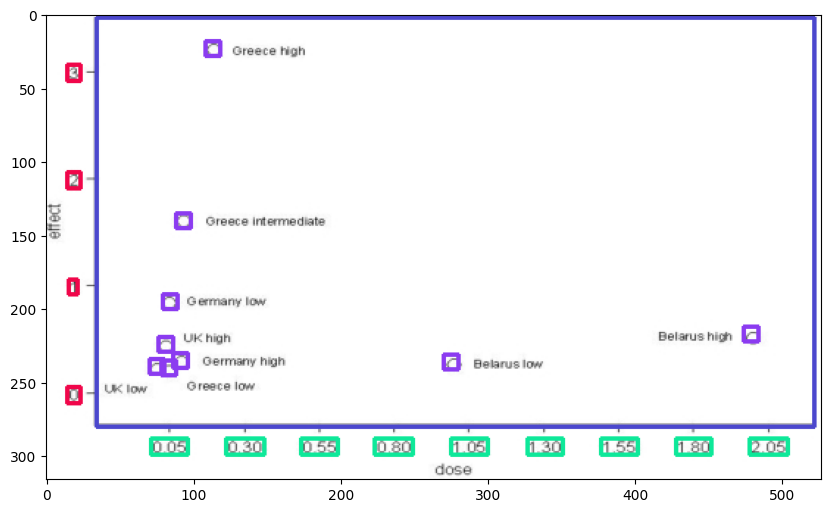

could not convert string to float: '0.0x'


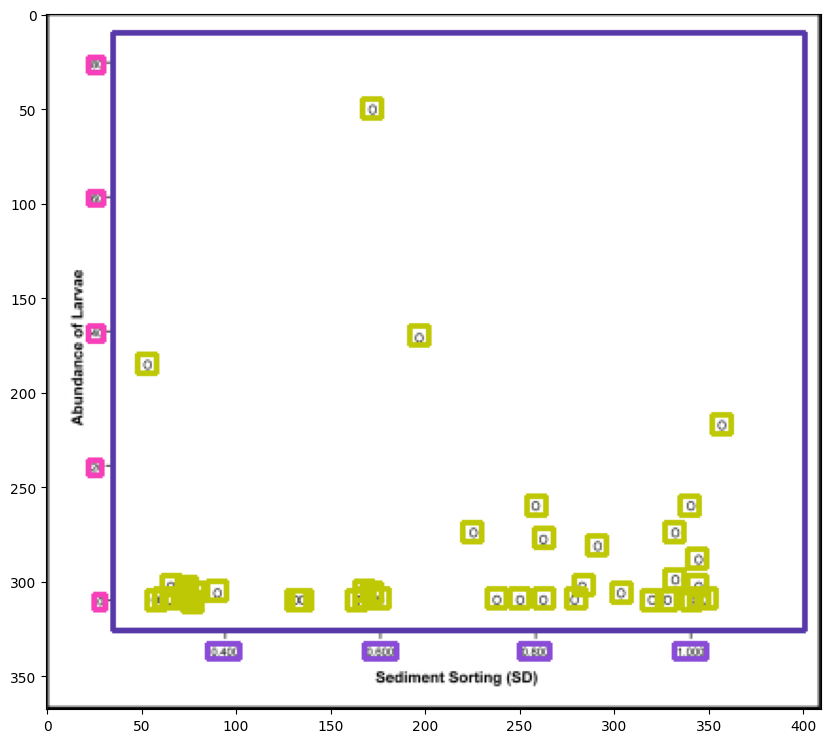

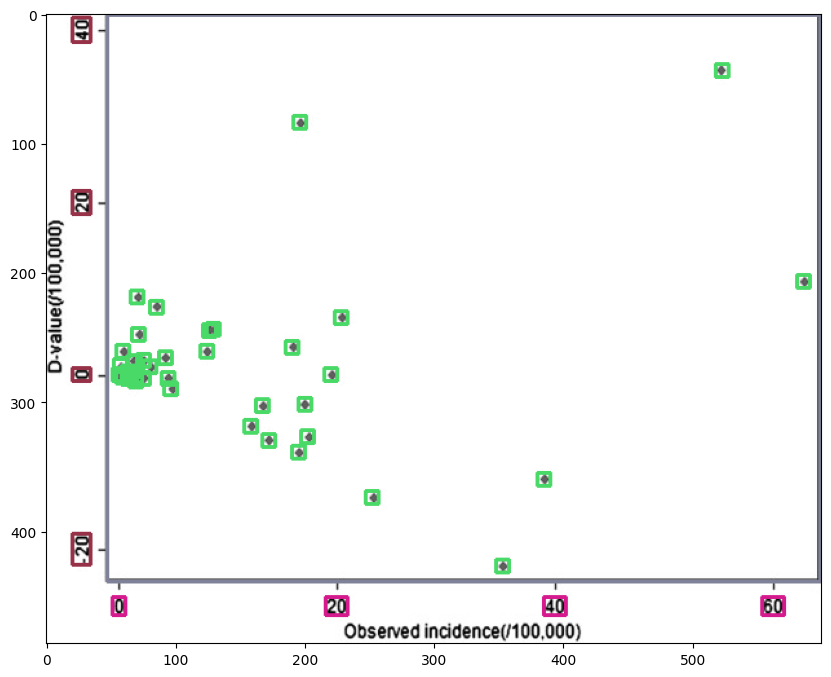

15146it [00:08, 1472.08it/s]

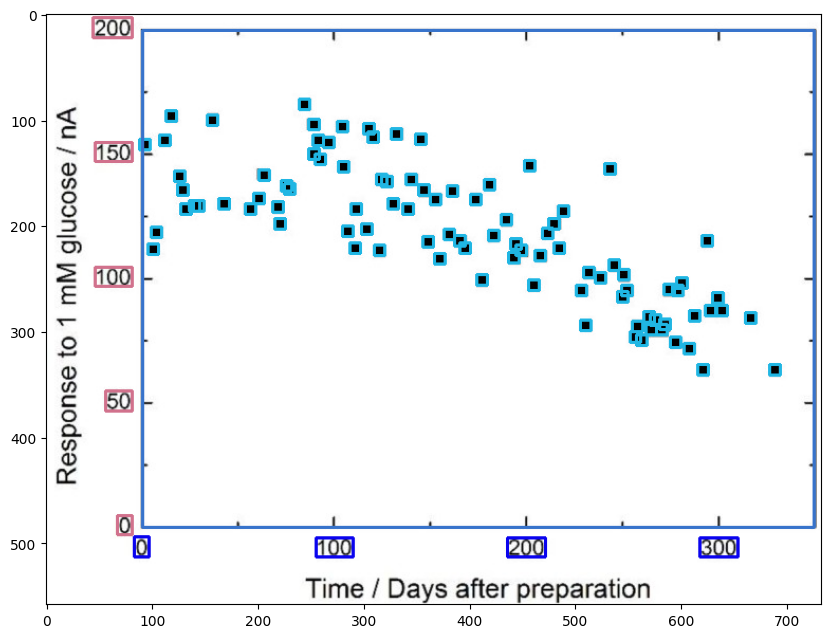

could not convert string to float: '10^{-2}'
could not convert string to float: '10^{4}'
could not convert string to float: '2x10^{5}'


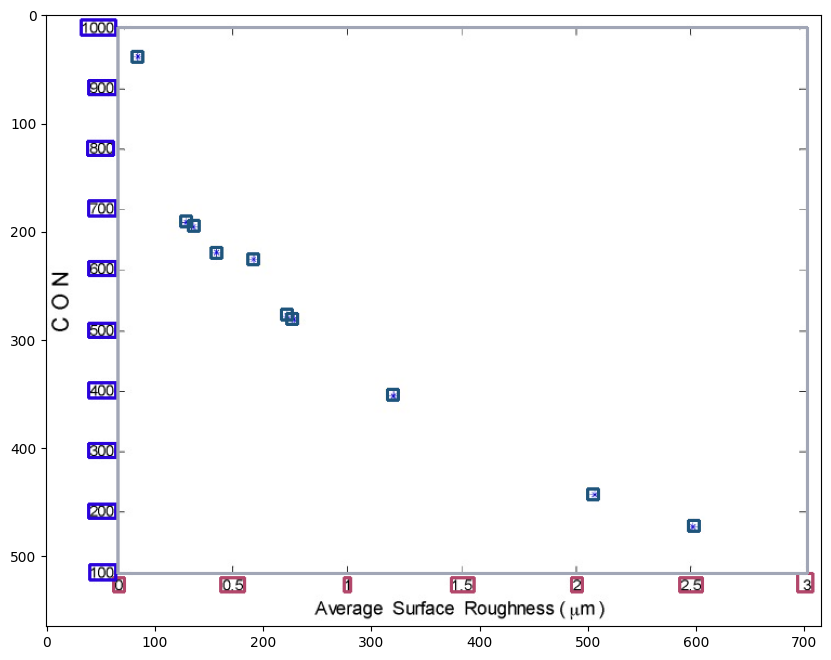

15841it [00:09, 1072.15it/s]

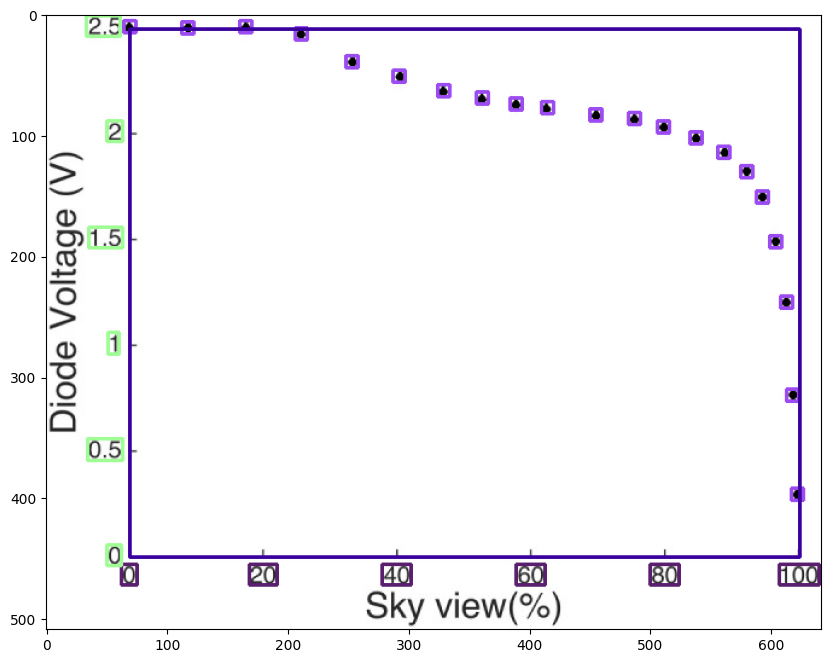

16347it [00:09, 1104.94it/s]

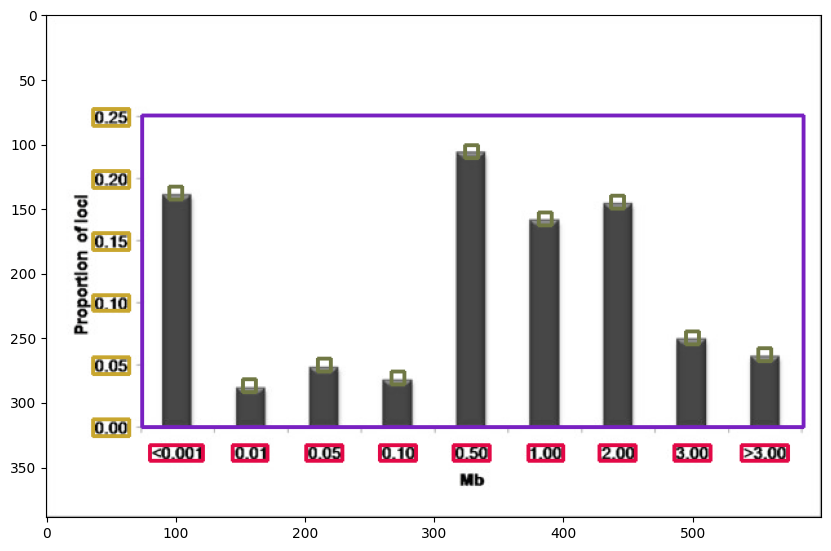

16737it [00:09, 1073.72it/s]

'0'
list index out of range





17329it [00:10, 1549.10it/s]

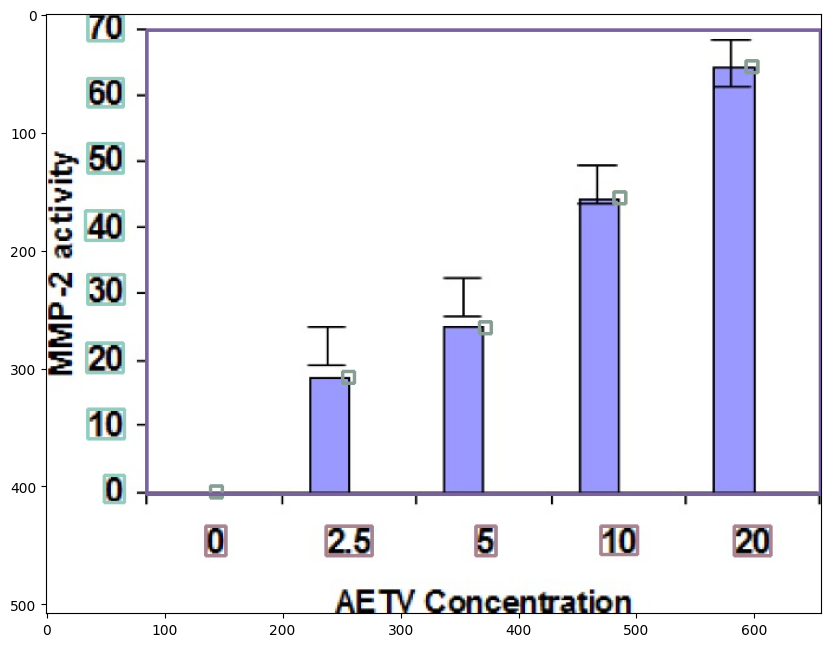

17616it [00:10, 1177.53it/s]

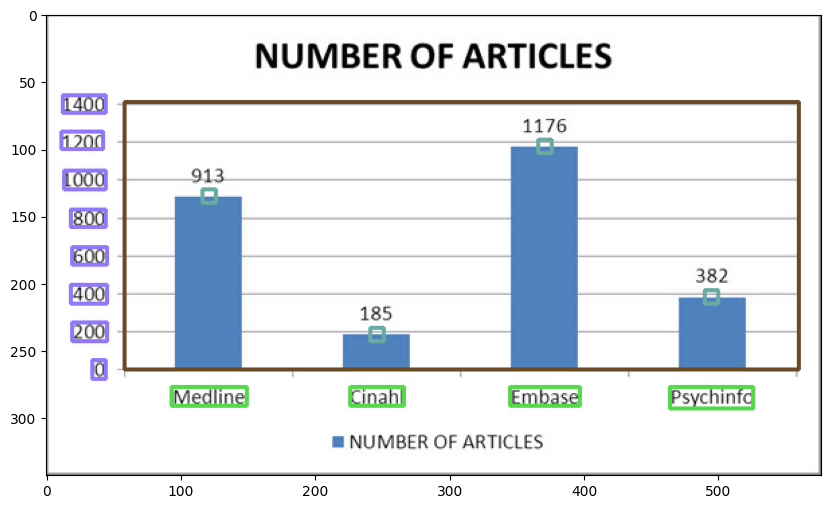

18261it [00:11, 1280.69it/s]



could not convert string to float: '10^7'


'[unnamed category #6]'


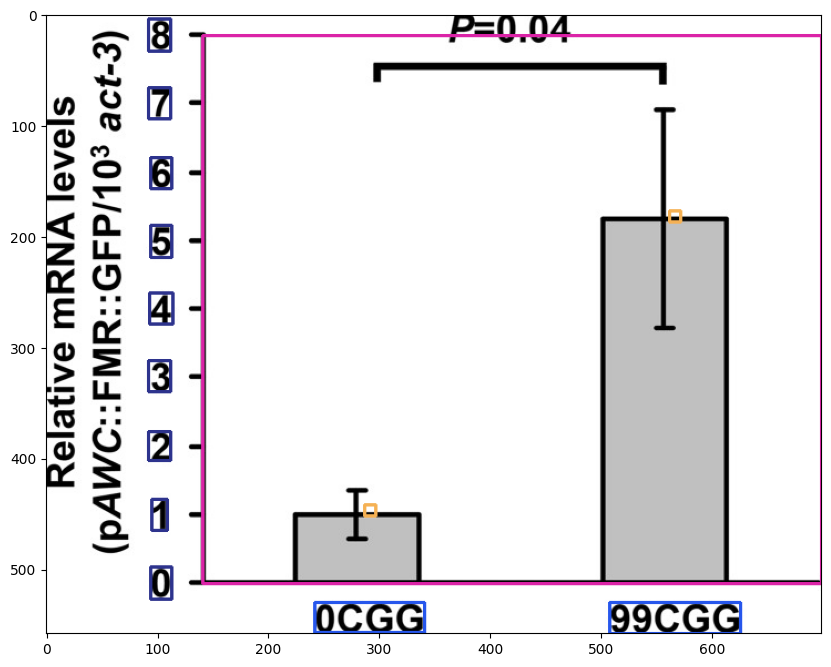

18447it [00:11, 869.37it/s] 

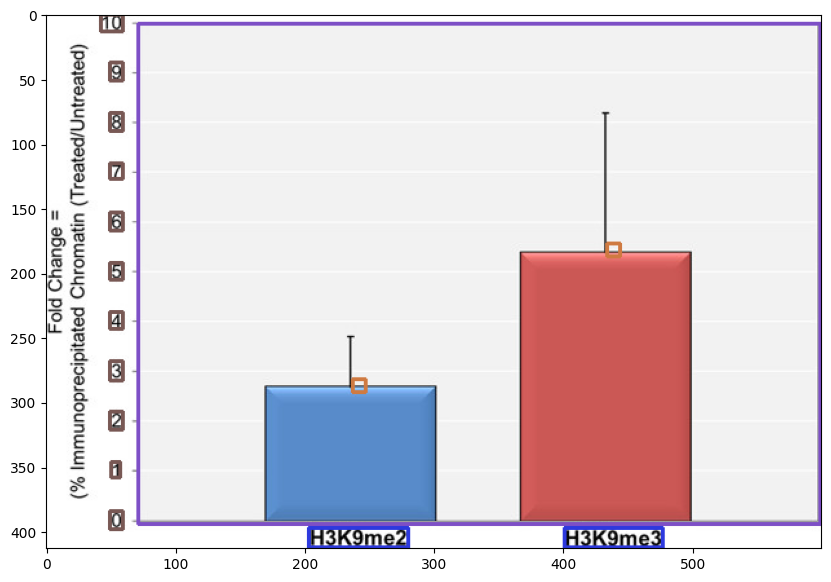

18592it [00:11, 590.68it/s]

19069it [00:12, 953.16it/s]

'[unnamed category #8]'


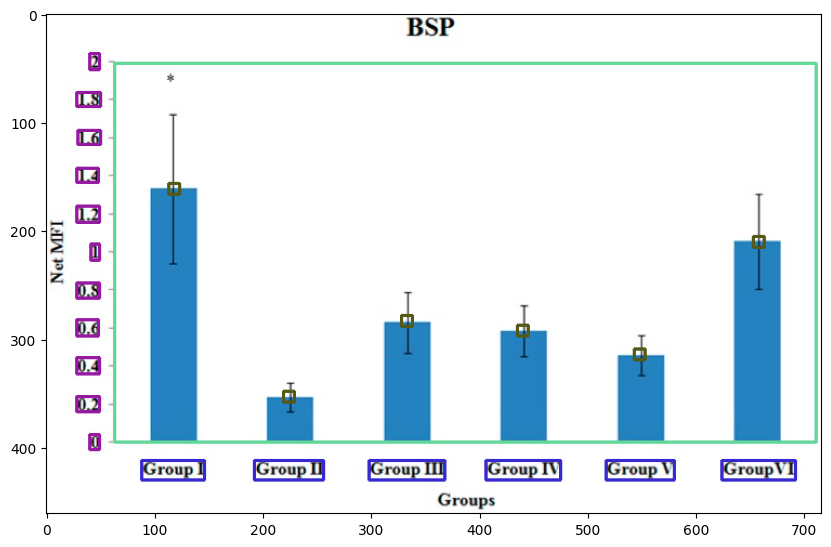

19415it [00:12, 913.83it/s]

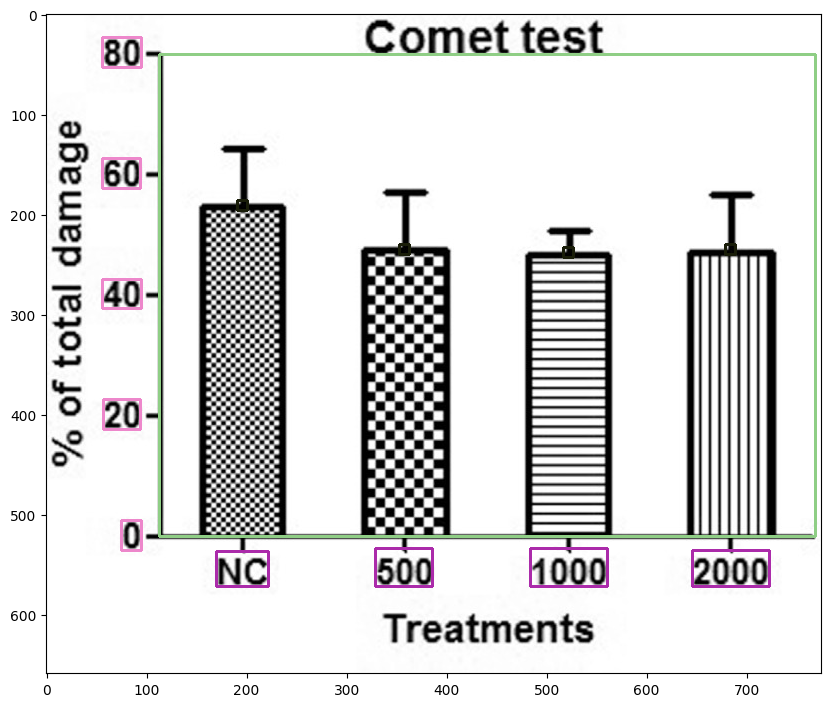

19563it [00:12, 697.26it/s]

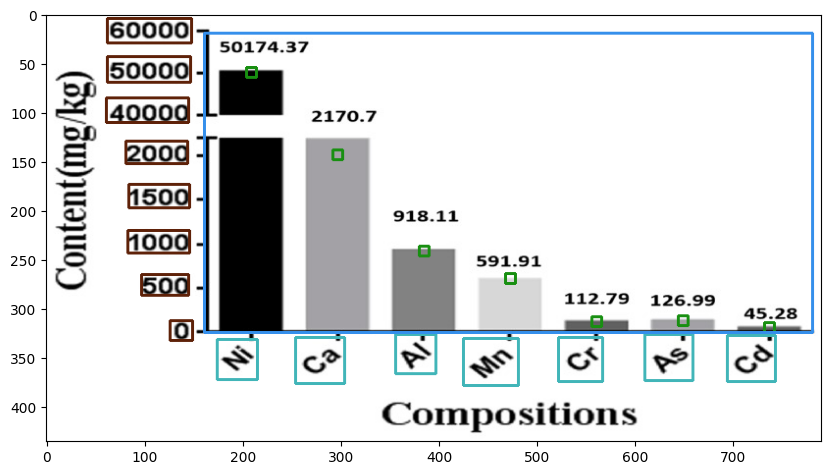

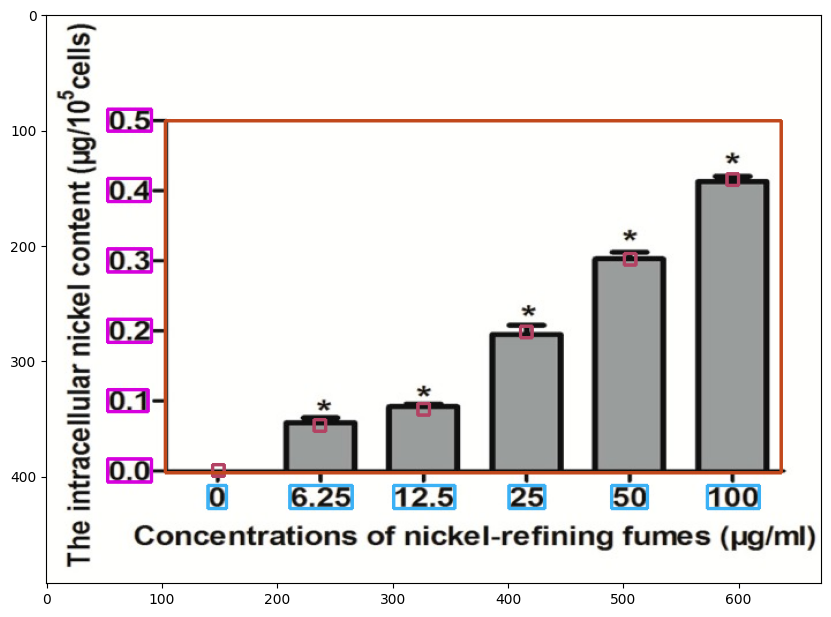

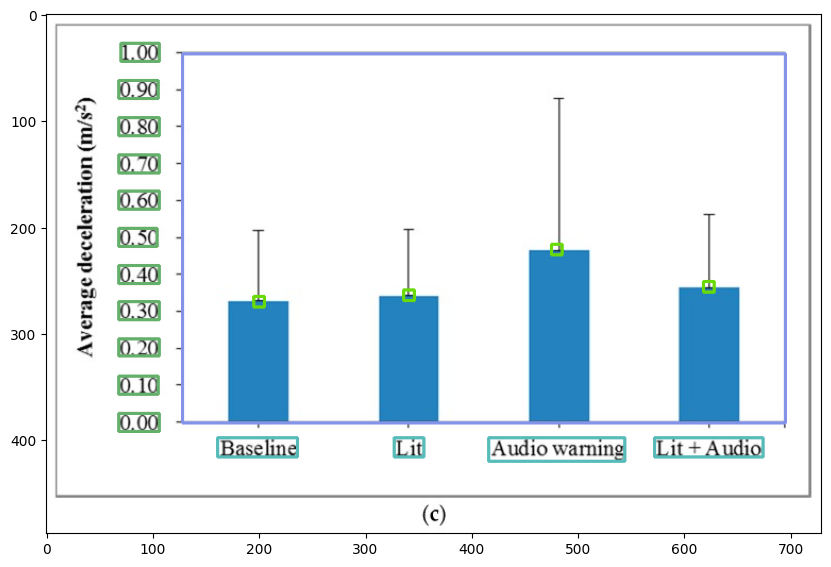

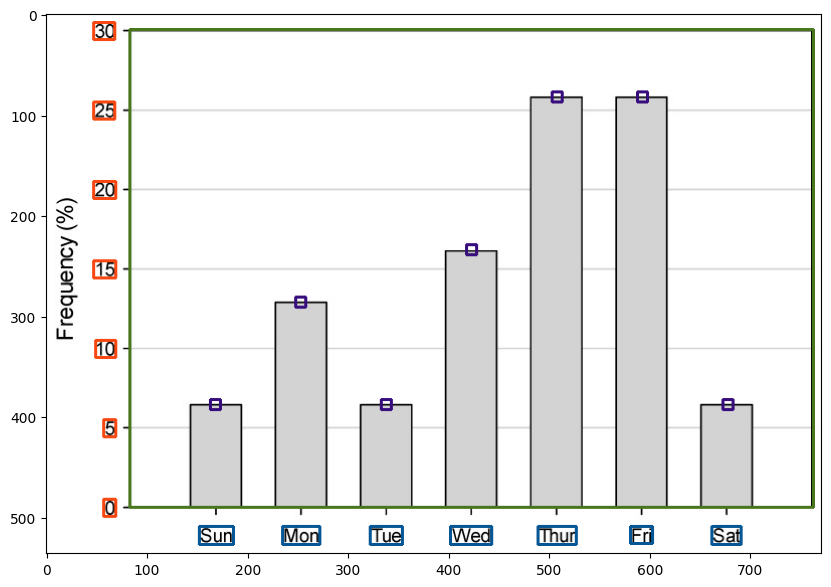

19680it [00:13, 274.15it/s]

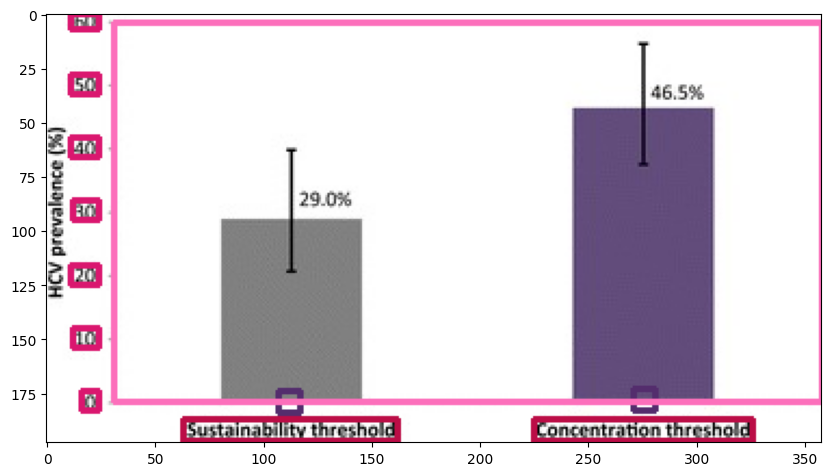

20065it [00:14, 441.31it/s]

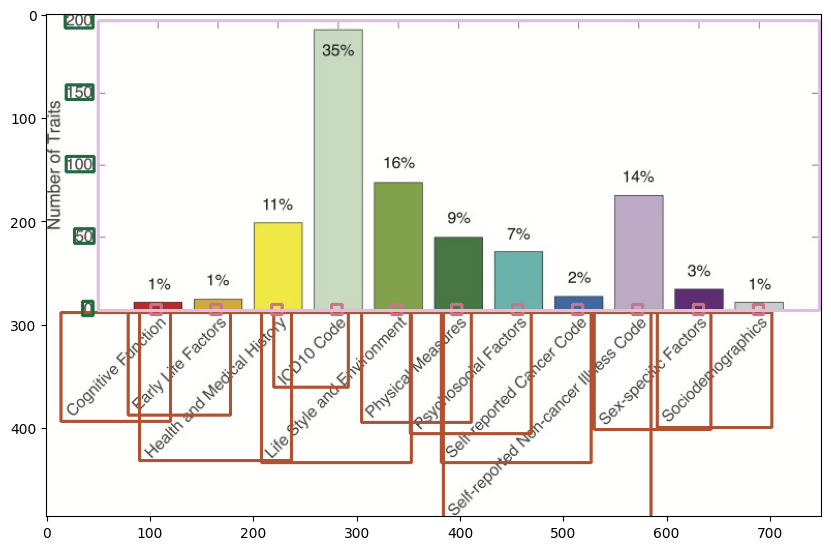

20725it [00:14, 805.32it/s]

'[unnamed category #11]'

could not convert string to float: '10^5'


21057it [00:15, 1011.77it/s]

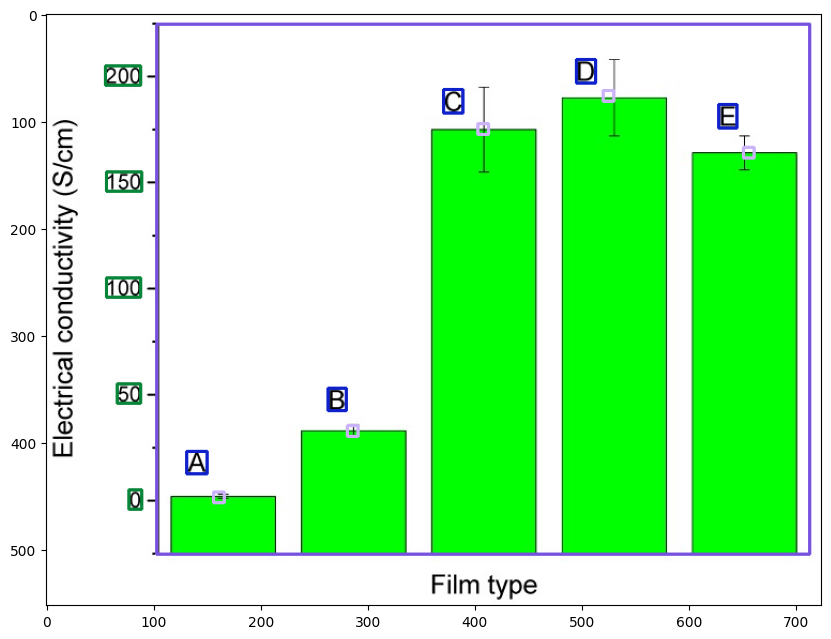

could not convert string to float: '10^{-1}'


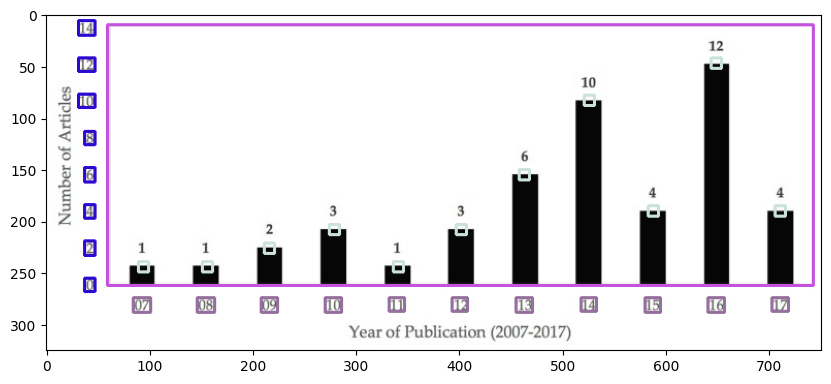

21199it [00:15, 527.04it/s] 

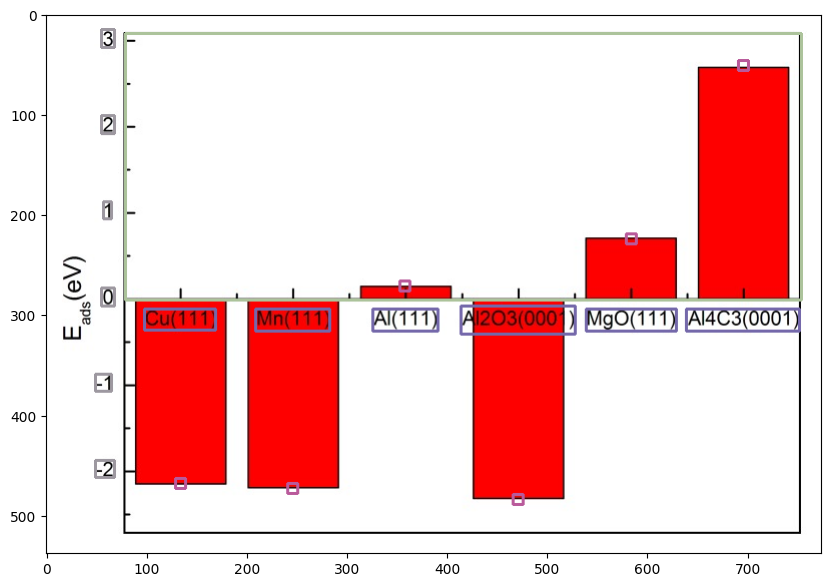

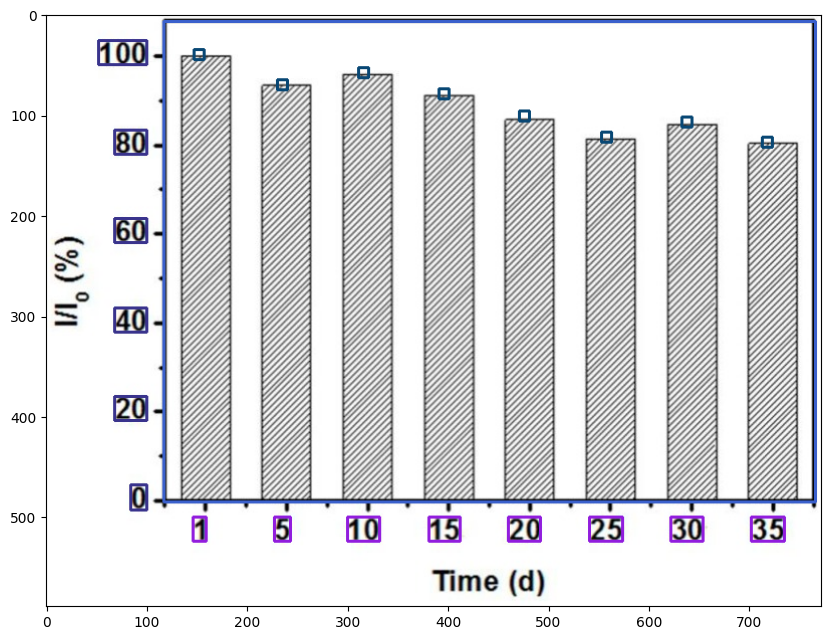

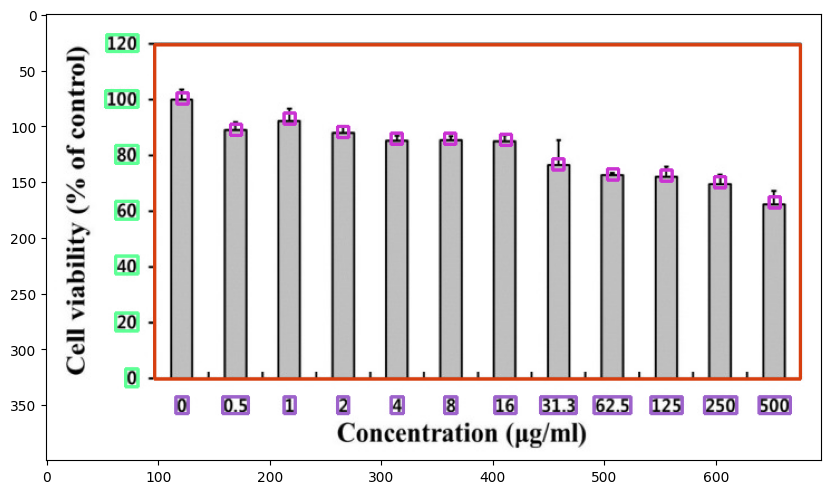

21456it [00:16, 344.24it/s]

'[unnamed category #4]'
'[unnamed category #0]'


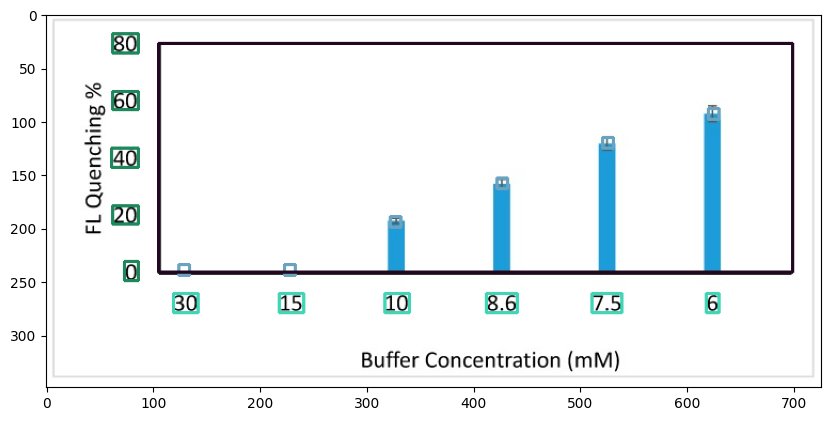

22923it [00:17, 1317.28it/s]


In [14]:
index=0
failed=0
TTH = 0.05
add_data=0
for imgpth,annot in tqdm(zip(train_images,train_annots)):
    try:
        v = json.load(open(annot))
        k = os.path.split(annot)[-1].replace(".json","")
        try:
            assert v["task1"]["output"]["chart_type"] in ALLOWED_CHARTS, "assert1"
            assert len(v["task6"]["output"]["data series"])==1,"assert2"
            v["task4"]["output"]["_plot_bb"]
            v["task2"]["output"]["text_blocks"]
            ctypee=v["task1"]["output"]["chart_type"]
            v["task4"]["output"]["axes"]
            if 'x-axis-2' in  v["task4"]["output"]["axes"]:
                assert len(v["task4"]["output"]["axes"]['x-axis-2'])==0,"assert3"
            if 'y-axis-2' in  v["task4"]["output"]["axes"]:
                assert len(v["task4"]["output"]["axes"]['y-axis-2'])==0,"assert4"
        except Exception as e:
            failed+=1            
            continue
        height,width=cv2.imread(imgpth).shape[:2]
        polygon = get_line_bboxes_new(v, ctypee)
        h,w,x,y = list(v["task4"]["output"]["_plot_bb"].values())
        polygon.append([3+ALLOWED_CHARTS[ctypee],x+w/2,y+h/2,w,h])
        for i in range(len(polygon)):
            polygon[i][0] = str(polygon[i][0])
            x,y,w,h = polygon[i][1:]
            # x = x-w/2
            # y = y-h/2
            polygon[i][1] = str(x/width)
            polygon[i][3] = str(w/width)
            polygon[i][2] = str(y/height)
            polygon[i][4] = str(h/height)

        with open(f"./dataset/train/labels/{k}.txt", "w") as f:    
            f.write("\n".join([" ".join(p) for p in polygon]))
        shutil.copy(imgpth,"./dataset/train/images")
        if np.random.rand()<TTH:
            draw_boxes(imgpth, f"./dataset/train/labels/{k}.txt")
        add_data+=1
    except Exception as e:
        print(e)
        failed+=1

In [15]:
train_images1 = {}
for x in sorted(glob.glob("./ICPR2022_CHARTINFO_UB_UNITEC_PMC_TEST_v2.1/chart_images/*/*/*")):
    train_images1["".join(os.path.split(x)[-1].split(".")[:-1])] = x
train_annots1 = {}
for x in sorted(glob.glob("./ICPR2022_CHARTINFO_UB_UNITEC_PMC_TEST_v2.1/final_full_GT/*/*/*.json")):
    train_annots1["".join(os.path.split(x)[-1].split(".")[:-1])] = x

 82%|█████████████████████████████████████████████████████████████████████████▍               | 10935/13259 [00:00<00:00, 27175.44it/s]

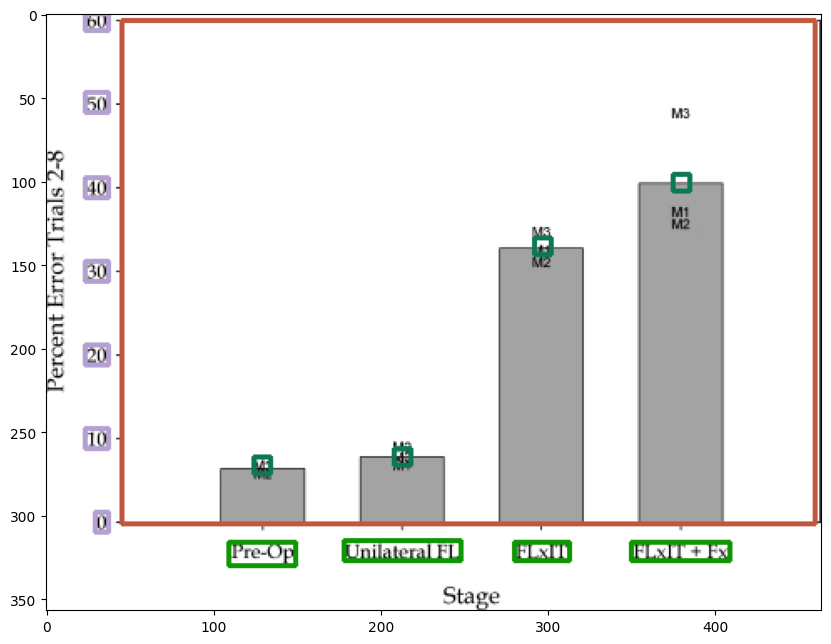

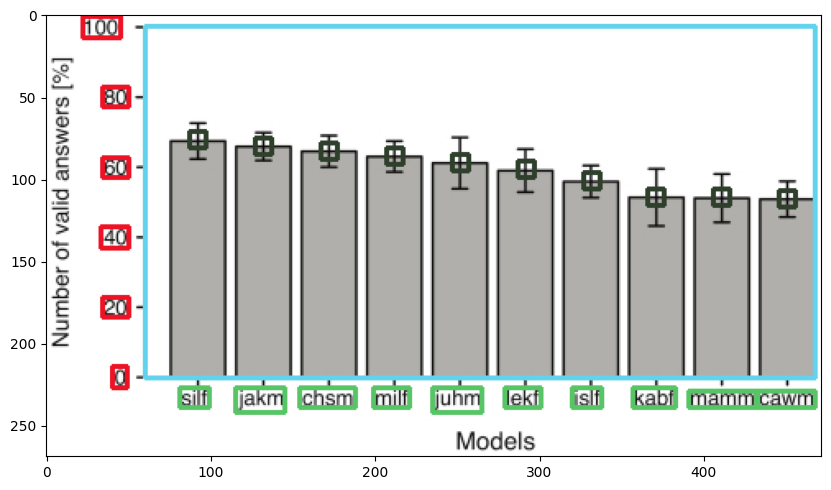

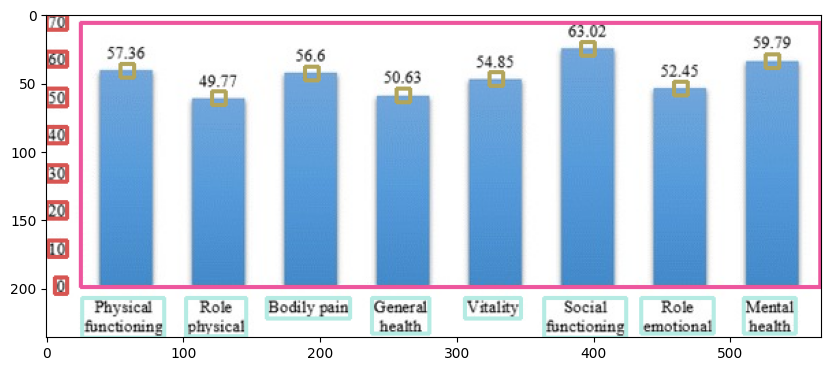

'[unnamed category #5]'
could not convert string to float: '0*10^{0}'


'[unnamed category #10]'









'[unnamed category #21]'




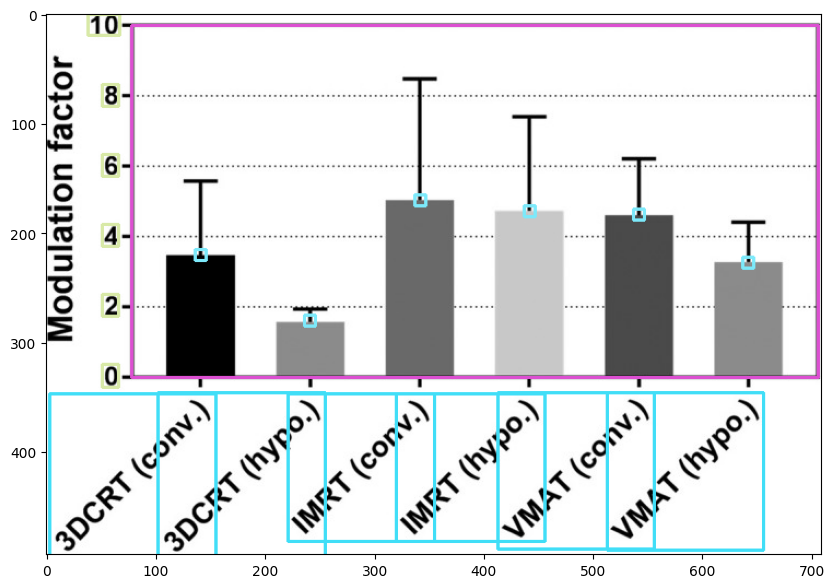


'[unnamed category #10]'




'[unnamed category #5]'

'[unnamed category #4]'
could not convert string to float: 'S00'








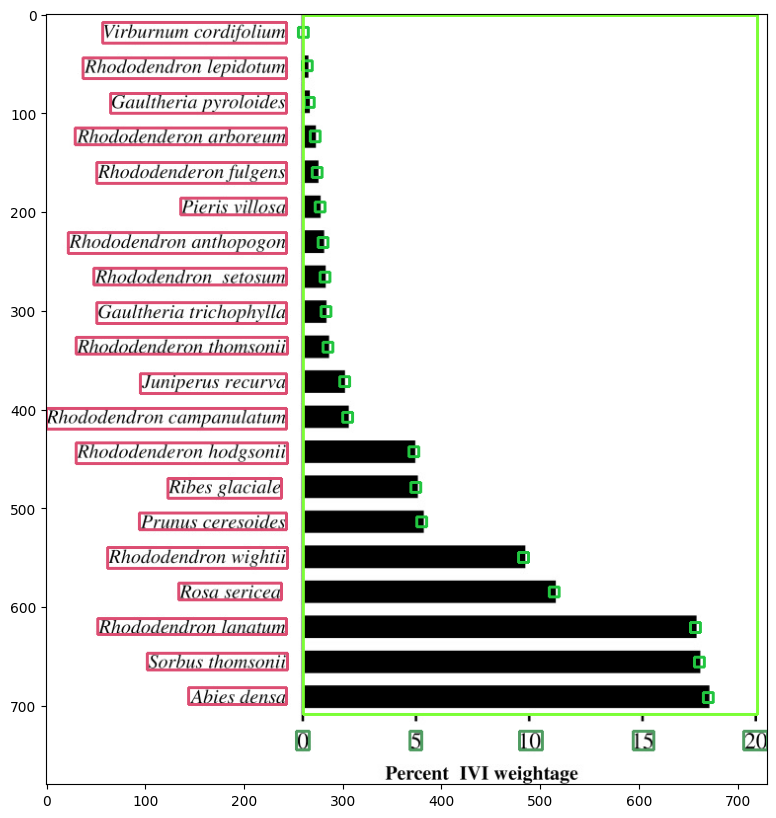

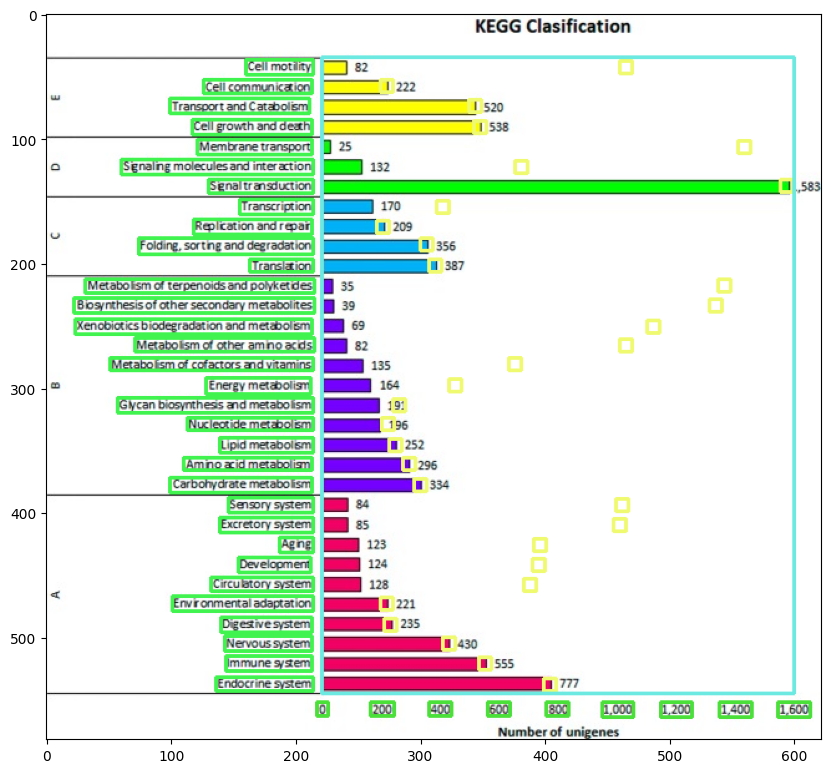

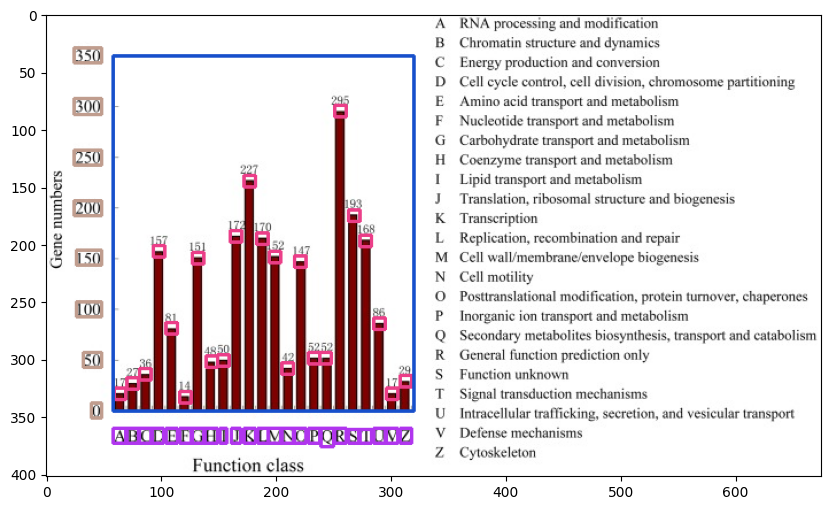

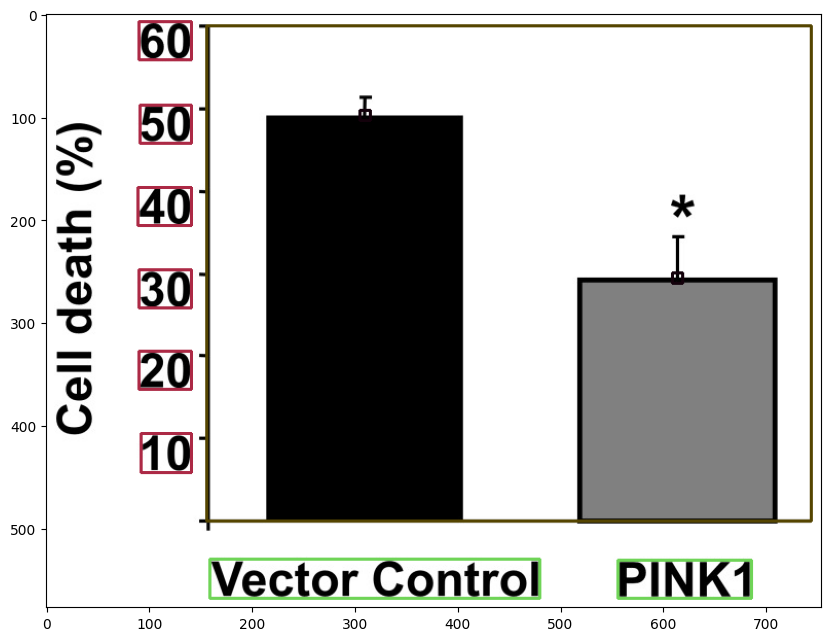

 98%|████████████████████████████████████████████████████████████████████████████████████████▎ | 13016/13259 [00:04<00:00, 1782.97it/s]


list index out of range


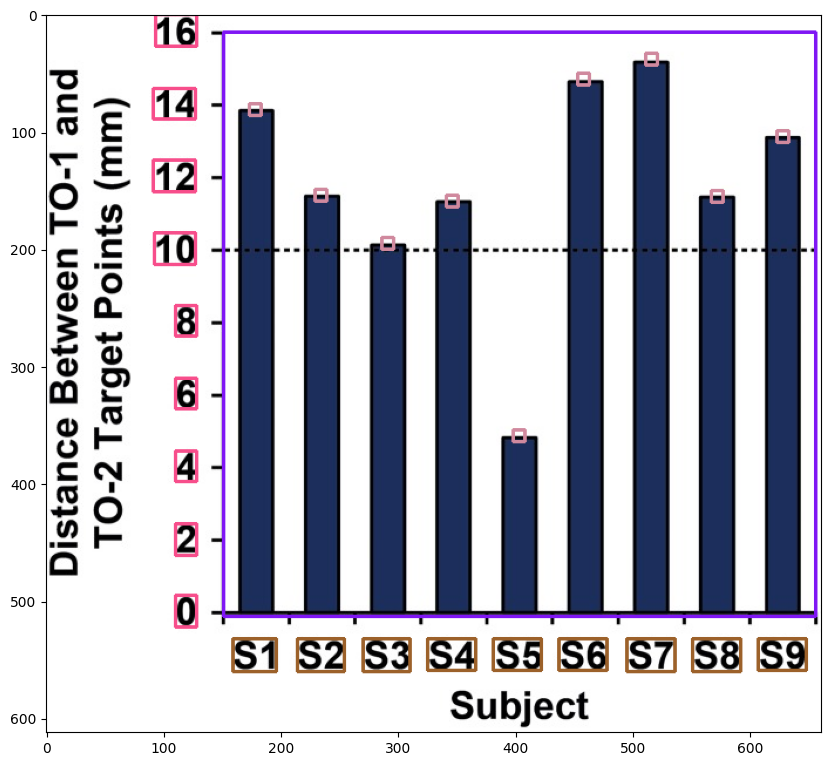

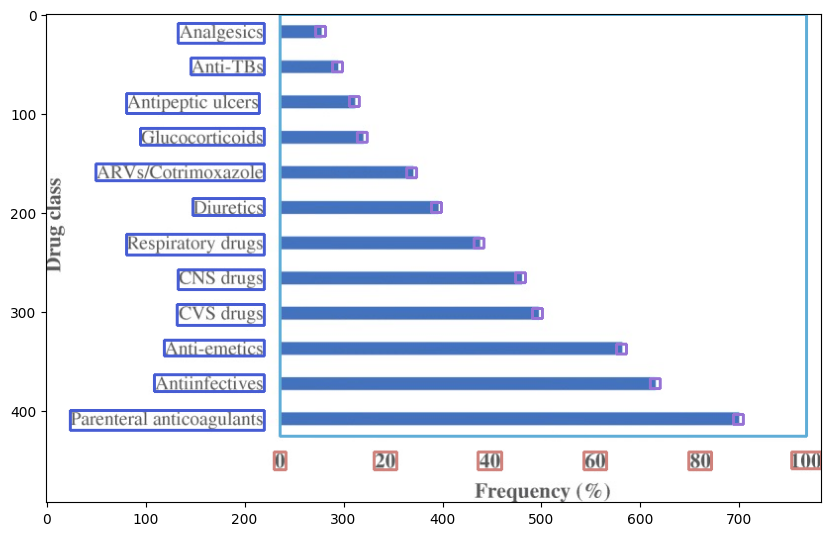



could not convert string to float: '10^{4}'







list index out of range
list index out of range


100%|██████████████████████████████████████████████████████████████████████████████████████████| 13259/13259 [00:05<00:00, 2584.62it/s]


In [16]:
index=0
failed=0
TTH = 0.05
for k in tqdm(train_annots1):
    try:
        imgpth = train_images1[k]
        annot = train_annots1[k]
        v = json.load(open(annot))
        k = os.path.split(annot)[-1].replace(".json","")
        try:
            assert v["task1"]["output"]["chart_type"] in ALLOWED_CHARTS
            assert len(v["task6"]["output"]["data series"])==1
            v["task4"]["output"]["_plot_bb"]
            v["task2"]["output"]["text_blocks"]
            ctypee=v["task1"]["output"]["chart_type"]
            v["task4"]["output"]["axes"]
            if 'x-axis-2' in  v["task4"]["output"]["axes"]:
                assert len(v["task4"]["output"]["axes"]['x-axis-2'])==0
            if 'y-axis-2' in  v["task4"]["output"]["axes"]:
                assert len(v["task4"]["output"]["axes"]['y-axis-2'])==0
        except:
            failed+=1            
            continue
        height,width=cv2.imread(imgpth).shape[:2]
        polygon = get_line_bboxes_new(v, ctypee)
        h,w,x,y = list(v["task4"]["output"]["_plot_bb"].values())
        polygon.append([3+ALLOWED_CHARTS[ctypee],x+w/2,y+h/2,w,h])
        for i in range(len(polygon)):
            polygon[i][0] = str(polygon[i][0])
            x,y,w,h = polygon[i][1:]
            # x = x-w/2
            # y = y-h/2
            polygon[i][1] = str(x/width)
            polygon[i][3] = str(w/width)
            polygon[i][2] = str(y/height)
            polygon[i][4] = str(h/height)

        with open(f"./dataset/train/labels/{k}.txt", "w") as f:    
            f.write("\n".join([" ".join(p) for p in polygon]))
        shutil.copy(imgpth,"./dataset/train/images")
        if np.random.rand()<TTH:
            draw_boxes(imgpth, f"./dataset/train/labels/{k}.txt")
        add_data+=1
    except Exception as e:
        print(e)
        failed+=1

In [18]:
add_data

1027